# Домашняя работа

**MNIST**

---

ФИО: Петрунина Мария Владимировна


---

Подключение библиотек

In [1]:
import numpy as np
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

##Выборки

Импортирование датасета и разделение на тренировочную и тестовую выборки

In [ ]:
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Получение общего числа объектов и их ярлыков

In [ ]:
train_samples_len = len(train_set)
test_samples_len = len(test_set)
image_shape = train_set[0][0].shape
classes_len = len(train_set.classes)
classes_labels = train_set.classes

print(f'{train_samples_len},\n{test_samples_len},\n{image_shape},\n{classes_len},\n{classes_labels}')

60000,
10000,
torch.Size([1, 28, 28]),
10,
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Создание словаря

In [ ]:
labels_dict = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

Вывод картинок

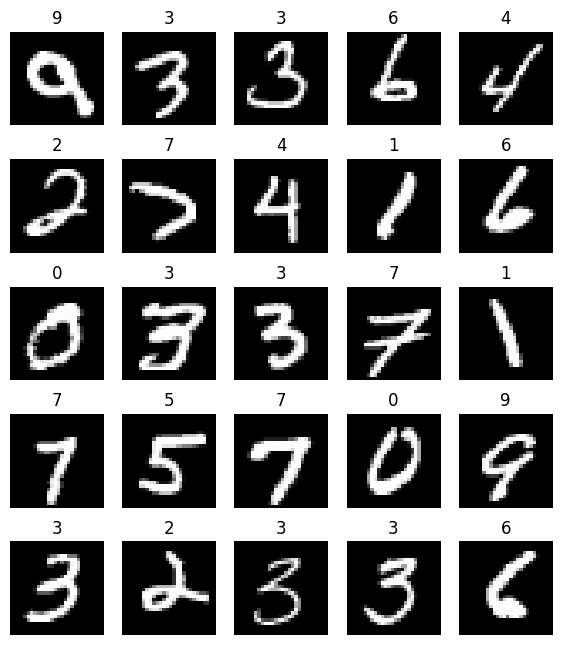

In [ ]:
fig = plt.figure(figsize=(7, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_index]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle=False)

##Создание модели

In [ ]:
class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 4 * 4,120)
    self.fc2 = nn.Linear(120,80)
    self.fc3 = nn.Linear(80,10)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1,16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
net = NN()
net


NN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

##Выходная размерность карты признаков

Без падинга:
$$
(w,h) = (\frac{mW - kW + 1}{s}, \frac{mH - kH + 1}{s})
$$
С падингами:
$$
(\frac{mW+2p-kW+1}{s}, \frac{mH+2p-kH+1}{s}=(w,h)
$$
где $$ (w,h)\text{ - вычисляемый размер сверточной карты;} $$
$$ mW\text{ - ширина предыдущей карты;} $$
$$ mH\text{ - высота предыдущей карты;} $$
$$ kW\text{ - ширина ядра;} $$
$$ kH\text{ - высота ядра;} $$
$$ s\text{ - шаг свертки;} $$
$$ p\text{ - количество строк падингов с одной стороны по вертикали или горизонтали;} $$

### Действие 1

В моем случае без падинга
сверточный слой 1 (Conv2d):
Размер ядра: $$kW = 5, kH = 5$$
Padding: $$p = 0$$
Ширина предыдущей карты: $$ mW = 28 $$
Высота предыдущей карты: $$ mH = 28 $$
Выходной размер: $$ (28 - 5 + 1, 28 - 5 + 1) = (24, 24) $$
Глубина 6, значит размер: $$ (6, 24, 24) $$

### Действие 2

Maxpooling:
stride: $$ s = 2 $$
значит выходной размер: $$(\frac{24}{2}, \frac{24}{2}) = (12,12) $$
считая глубину: $$ (6, 12,12) $$

### Действие 3

В моем случае без падинга
сверточный слой 1 (Conv2d):
Размер ядра: $$kW = 5, kH = 5$$
Padding: $$p = 0$$
Ширина предыдущей карты: $$ mW = 28 $$
Высота предыдущей карты: $$ mH = 28 $$
Выходной размер: $$ (12 - 5 + 1, 12 - 5 + 1) = (8, 8) $$
с глубиной опять же: $$ (16, 8, 8) $$


### Действие 4. Итог

Maxpooling второй раз:
stride: $$ s = 2 $$
значит выходной размер: $$(\frac{8}{2}, \frac{8}{2}) = (4, 4) $$
считая глубину: $$ (16, 4, 4) $$

##Обучение модели

In [ ]:
loss_net = torch.nn.CrossEntropyLoss()

lr = 0.001

optimizer = torch.optim.Adam(net.parameters(), lr = lr)

num_epochs = 6

train_losses = []

for epoch in range(num_epochs):
    real_loss = 0.0

    for i, (X_batch, y_batch) in enumerate(train_loader):  # Используем DataLoader
        optimizer.zero_grad()
        inputs, labels = X_batch, y_batch

        y_pred = net(X_batch)

        loss = loss_net(y_pred, labels)

        loss.backward()
        optimizer.step()

        real_loss += loss.item()

        if i % 500 == 499:  # Вывод каждые 500 батчей
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {real_loss / 500:.4f}")
            real_loss = 0.0
    avg_loss = real_loss/ len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print('\nDONE')


Epoch 1, Batch 500, Loss: 0.5476
Epoch 1, Batch 1000, Loss: 0.1662
Epoch 1, Batch 1500, Loss: 0.1099
Epoch 1, Loss: 0.0206
Epoch 2, Batch 500, Loss: 0.0815
Epoch 2, Batch 1000, Loss: 0.0832
Epoch 2, Batch 1500, Loss: 0.0713
Epoch 2, Loss: 0.0125
Epoch 3, Batch 500, Loss: 0.0581
Epoch 3, Batch 1000, Loss: 0.0570
Epoch 3, Batch 1500, Loss: 0.0542
Epoch 3, Loss: 0.0104
Epoch 4, Batch 500, Loss: 0.0415
Epoch 4, Batch 1000, Loss: 0.0444
Epoch 4, Batch 1500, Loss: 0.0446
Epoch 4, Loss: 0.0088
Epoch 5, Batch 500, Loss: 0.0315
Epoch 5, Batch 1000, Loss: 0.0400
Epoch 5, Batch 1500, Loss: 0.0317
Epoch 5, Loss: 0.0078
Epoch 6, Batch 500, Loss: 0.0294
Epoch 6, Batch 1000, Loss: 0.0293
Epoch 6, Batch 1500, Loss: 0.0357
Epoch 6, Loss: 0.0058

DONE


##График

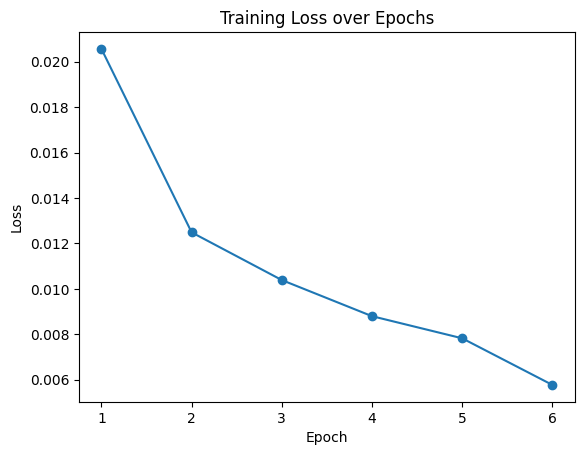

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
test_dataiter = iter(test_loader)
images,labels = next(test_dataiter)

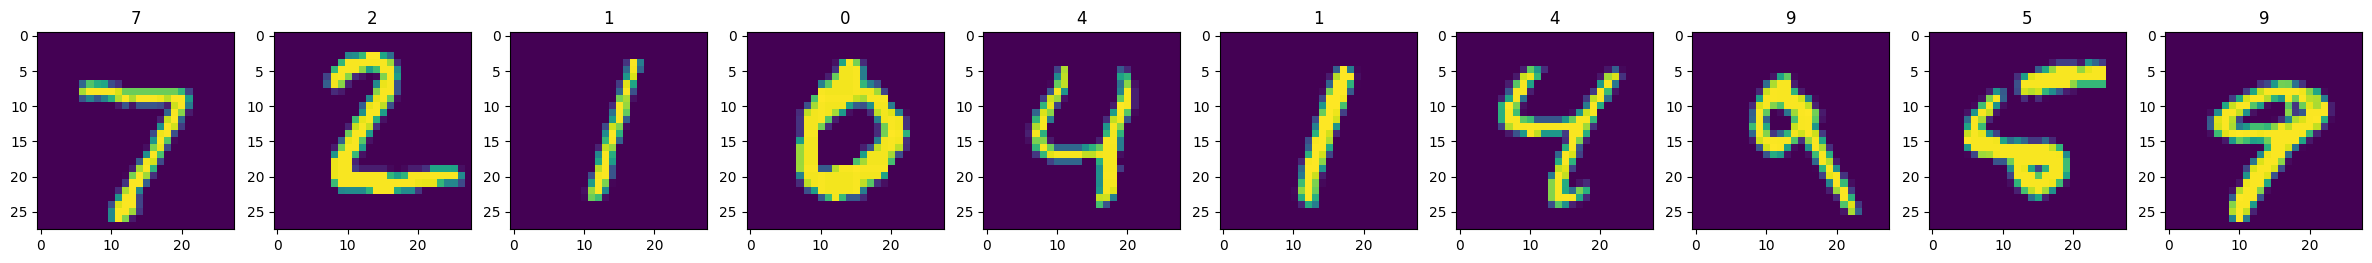

In [ ]:
def show_images(img,labels):
  f, axes = plt.subplots(1,10,figsize = (30,5))
  for i, axis in enumerate(axes):
    axes[i].imshow(np.squeeze(np.transpose(img[i].numpy(),(1,2,0))))
    axes[i].set_title(labels[i].numpy())
  plt.show()

show_images(images,labels)

In [ ]:
predict_classes = np.argmax(net(images).detach().numpy(),axis = 1)

In [ ]:
list(map(lambda x: labels_dict[x],predict_classes))

['7',
 '2',
 '1',
 '0',
 '4',
 '1',
 '4',
 '9',
 '5',
 '9',
 '0',
 '6',
 '9',
 '0',
 '1',
 '5',
 '9',
 '7',
 '8',
 '4',
 '9',
 '6',
 '6',
 '5',
 '4',
 '0',
 '7',
 '4',
 '0',
 '1',
 '3',
 '1']

##Тестовая выборка

Проверка точности таким образом(как процент), затем переобучила и нашла другие показатели

In [ ]:
with torch.no_grad():
    net.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Точность (accuracy) {100 * correct / total}')


Точность (accuracy) 98.77


Значения на переобученной: (заново все запускала кроме блока кода выше)

## Тестовая выборка 2

In [ ]:
# Тестирование модели
all_labels = []
all_preds = []

with torch.no_grad():
    net.eval()
    for X_batch, y_batch in test_loader:
        outputs = net(X_batch)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(y_batch.numpy())
        all_preds.extend(preds.numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.9883
Test F1 Score: 0.9882


##Примеры

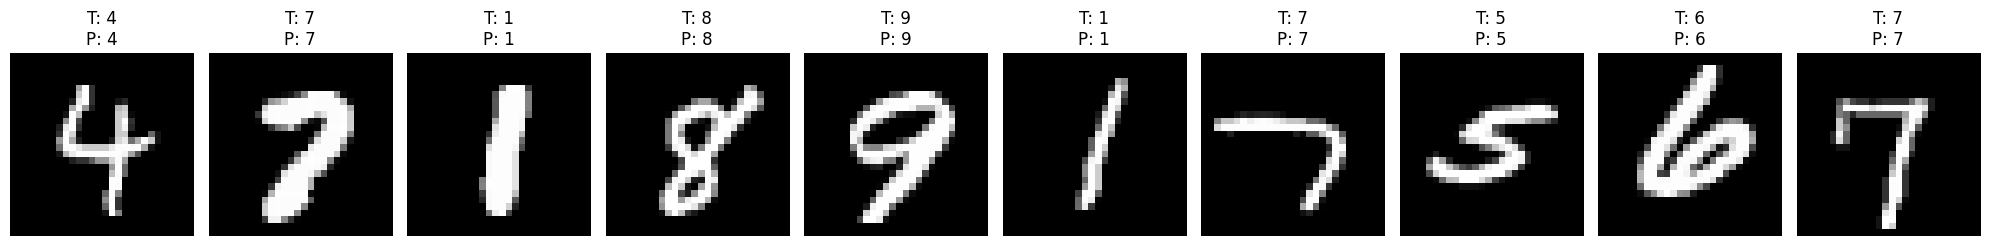

In [ ]:
# Вывод 10 случайных тестовых примеров
random_indices = torch.randint(0, len(test_set), (10,))
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

for i, idx in enumerate(random_indices):
    img, true_label = test_set[idx]
    img = img.unsqueeze(0)  # Add batch dimension
    pred_label = torch.argmax(net(img)).item()
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"T: {labels_dict[true_label]}\nP: {labels_dict[pred_label]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


##Эксперименты

Эксперименты с learning_rate и batch_size

###SGD

In [ ]:
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

train_set = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

params_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [3, 5, 7],
    'batch_size': [16, 32, 64]
}

grid = ParameterGrid(params_grid)

best_accuracy = 0.0
best_hyperparams = None

for params in grid:
    print(params)
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    model = TheModelClass()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Эпоха №{epoch+1}")
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'accuracy:{accuracy}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = params
        best_model_state_dict = model.state_dict()

print("Лучшие гиперпараметры:", best_hyperparams)
print(best_accuracy)

torch.save(best_model_state_dict, "best_model.pth")

{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.81665
{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:0.8824833333333333
{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 7}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
Эпоха №6
Эпоха №7
accuracy:0.9353
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.9748166666666667
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:0.9845
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 7}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
Эпоха №6
Эпоха №7
accuracy:0.9876333333333334
{'batch_size': 16, 'learning_rate': 0.1, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.9904333333333334
{'batch_size': 16, 'learning_rate': 0.1, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:0.99465
{'batch

###Оптимизатор Адам

In [ ]:
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

train_set = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

params_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [3, 5, 7],
    'batch_size': [16, 32, 64]
}

grid = ParameterGrid(params_grid)

best_accuracy = 0.0
best_hyperparams = None

for params in grid:
    print(params)
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    model = TheModelClass()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Эпоха №{epoch+1}")
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'accuracy:{accuracy}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = params
        best_model_state_dict = model.state_dict()

print("Лучшие гиперпараметры:", best_hyperparams)
print(best_accuracy)

torch.save(best_model_state_dict, "best_model.pth")

{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.98945
{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:0.9935833333333334
{'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 7}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
Эпоха №6
Эпоха №7
accuracy:0.9954833333333334
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.10441666666666667
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:0.9751833333333333
{'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 7}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
Эпоха №6
Эпоха №7
accuracy:0.97615
{'batch_size': 16, 'learning_rate': 0.1, 'num_epochs': 3}
Эпоха №1
Эпоха №2
Эпоха №3
accuracy:0.10441666666666667
{'batch_size': 16, 'learning_rate': 0.1, 'num_epochs': 5}
Эпоха №1
Эпоха №2
Эпоха №3
Эпоха №4
Эпоха №5
accuracy:

###Измененная архитектура


In [ ]:
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle=False)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
loss_net = torch.nn.CrossEntropyLoss()

lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

num_epochs = 6

train_losses = []

for epoch in range(num_epochs):
    real_loss = 0.0

    for i, (X_batch, y_batch) in enumerate(train_loader):  # Используем DataLoader
        optimizer.zero_grad()
        inputs, labels = X_batch, y_batch

        y_pred = model(X_batch)

        loss = loss_net(y_pred, labels)

        loss.backward()
        optimizer.step()

        real_loss += loss.item()

        if i % 500 == 499:  # Вывод каждые 500 батчей
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {real_loss / 500:.4f}")
            real_loss = 0.0
    avg_loss = real_loss/ len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print('\nDONE')

Epoch 1, Batch 500, Loss: 0.5238
Epoch 1, Batch 1000, Loss: 0.2126
Epoch 1, Batch 1500, Loss: 0.1615
Epoch 1, Loss: 0.0296
Epoch 2, Batch 500, Loss: 0.1018
Epoch 2, Batch 1000, Loss: 0.1141
Epoch 2, Batch 1500, Loss: 0.1030
Epoch 2, Loss: 0.0184
Epoch 3, Batch 500, Loss: 0.0702
Epoch 3, Batch 1000, Loss: 0.0727
Epoch 3, Batch 1500, Loss: 0.0723
Epoch 3, Loss: 0.0145
Epoch 4, Batch 500, Loss: 0.0473
Epoch 4, Batch 1000, Loss: 0.0503
Epoch 4, Batch 1500, Loss: 0.0614
Epoch 4, Loss: 0.0121
Epoch 5, Batch 500, Loss: 0.0351
Epoch 5, Batch 1000, Loss: 0.0432
Epoch 5, Batch 1500, Loss: 0.0501
Epoch 5, Loss: 0.0091
Epoch 6, Batch 500, Loss: 0.0286
Epoch 6, Batch 1000, Loss: 0.0395
Epoch 6, Batch 1500, Loss: 0.0323
Epoch 6, Loss: 0.0079

DONE


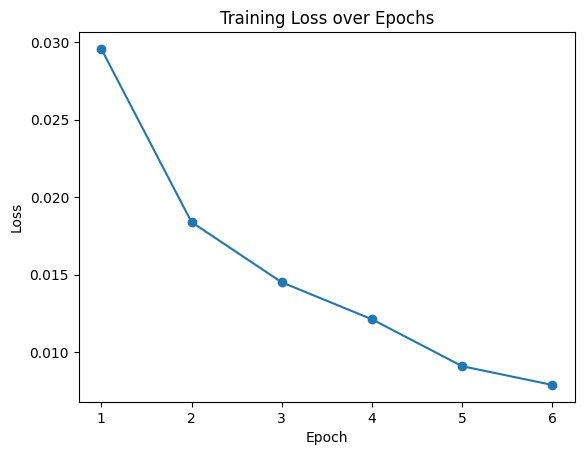

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Точность (accuracy) {100 * correct / total}')


Точность (accuracy) 97.47


###Еще одна архитектура

In [13]:
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle=False)

class New_m(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28*1,10)

  def forward(self,x):
    x = x.view(-1,28*28*1)
    x = self.fc1(x)
    x = F.softmax(x)
    return x

In [14]:
model_2 = New_m()
model_2

New_m(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [15]:
loss_net = torch.nn.CrossEntropyLoss()

lr = 0.001

optimizer = torch.optim.Adam(model_2.parameters(), lr = lr)

for epoch in tqdm(range(2)):

  real_loss = 0.0

  train_dataiter = iter(train_loader)
  for i,batch in enumerate(train_dataiter):

    X_batch,y_batch = batch

    optimizer.zero_grad()

    y_pred = model_2(X_batch)

    loss = loss_net(y_pred,y_batch)

    loss.backward()

    optimizer.step()

    real_loss += loss.item()

    if i%500 == 499:
      print(epoch+1,i+1,real_loss/500)
      real_loss = 0.0

print('\n')
print("DONE")

test_dataiter = iter(test_loader)
images,labels = next(test_dataiter)

predict_classes = np.argmax(model_2(images).detach().numpy(),axis = 1)

accuracy_score(labels.numpy(), predict_classes)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-13-7b62f174eed9>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


1 500 1.7862678315639495
1 1000 1.6210061802864075
1 1500 1.5971672041416167


 50%|█████     | 1/2 [00:10<00:10, 10.71s/it]

2 500 1.5758894720077514
2 1000 1.5725214614868164
2 1500 1.565674513578415


100%|██████████| 2/2 [00:20<00:00, 10.24s/it]



DONE


0.96875

###Эксперименты со сверточной архитектурой

In [16]:
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle=False)

class NN_new(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 4 * 4,120)
    self.fc2 = nn.Linear(120,80)
    self.fc3 = nn.Linear(80,40)
    self.fc4 = nn.Linear(40,10)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1,16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [17]:
model_3 = NN_new()
model_3

NN_new(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)

In [19]:
loss_net = torch.nn.CrossEntropyLoss()

lr = 0.001

optimizer = torch.optim.Adam(model_3.parameters(), lr = lr)

num_epochs = 6

train_losses = []

for epoch in range(num_epochs):
    real_loss = 0.0

    for i, (X_batch, y_batch) in enumerate(train_loader):  # Используем DataLoader
        optimizer.zero_grad()
        inputs, labels = X_batch, y_batch

        y_pred = model_3(X_batch)

        loss = loss_net(y_pred, labels)

        loss.backward()
        optimizer.step()

        real_loss += loss.item()

        if i % 500 == 499:  # Вывод каждые 500 батчей
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {real_loss / 500:.4f}")
            real_loss = 0.0
    avg_loss = real_loss/ len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print('\nDONE')

predict_classes = np.argmax(model_3(images).detach().numpy(),axis = 1)

# Тестирование модели
all_labels = []
all_preds = []

with torch.no_grad():
    model_3.eval()
    for X_batch, y_batch in test_loader:
        outputs = model_3(X_batch)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(y_batch.numpy())
        all_preds.extend(preds.numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")



Epoch 1, Batch 500, Loss: 0.6162
Epoch 1, Batch 1000, Loss: 0.1759
Epoch 1, Batch 1500, Loss: 0.1331
Epoch 1, Loss: 0.0232
Epoch 2, Batch 500, Loss: 0.0900
Epoch 2, Batch 1000, Loss: 0.0820
Epoch 2, Batch 1500, Loss: 0.0828
Epoch 2, Loss: 0.0144
Epoch 3, Batch 500, Loss: 0.0642
Epoch 3, Batch 1000, Loss: 0.0585
Epoch 3, Batch 1500, Loss: 0.0569
Epoch 3, Loss: 0.0119
Epoch 4, Batch 500, Loss: 0.0470
Epoch 4, Batch 1000, Loss: 0.0497
Epoch 4, Batch 1500, Loss: 0.0473
Epoch 4, Loss: 0.0092
Epoch 5, Batch 500, Loss: 0.0330
Epoch 5, Batch 1000, Loss: 0.0412
Epoch 5, Batch 1500, Loss: 0.0415
Epoch 5, Loss: 0.0082
Epoch 6, Batch 500, Loss: 0.0316
Epoch 6, Batch 1000, Loss: 0.0334
Epoch 6, Batch 1500, Loss: 0.0297
Epoch 6, Loss: 0.0069

DONE
Test Accuracy: 0.9879
Test F1 Score: 0.9878


##Вывод


1. Лучшие гиперпараметры: Adam: Learning Rate = 0.001, Batch Size = 16, Epochs = 7. SGD: Learning Rate = 0.1, Batch Size = 32, Epochs = 7.
2. Оптимизатор Adam показал лучшую скорость сходимости по сравнению с SGD.
3. Использование большего числа эпох или сложной архитектуры не улучшило результаты существенно. В примере других архитектур точность показала 97.47 и 96.88 (в процентах), то есть разница в пару процентов с первичной при тех же значениях. В то время как эксперименты со сверточной архитектурой показали минимальные различия, будто бы добавление или удаление слоев в этом случае роли не играет.
4. Для оптимизатора SGD вариантом с наихудшеми условиями был: batch_size: 64, learning_rate: 0.001, num_epochs: 5.
5. Для оптимизатора Adam 3 эпохи выдавали плохие значение accuracy, 5 и 7 работали хорошо.
6. На мой взгляд, лучше использовать Adam в таких задачах, так как он показывал высшую точность при 5-7 эпохах.
